In [1]:
#import the modules that I will require
import os
import numpy as np
import pandas as pd

import scipy
from scipy.optimize import curve_fit

import pylab as pyl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Setup the main directories using the environ dir
#Define the various directories
script_dir = os.getcwd()

#using dirname you can go up of one directory
main_dir = os.path.dirname(script_dir)

#then use join to define variables pointing to subdirectories
data_dir = os.path.join(main_dir,"Pcontrol/data")

#define an output directory with the results
results_dir = os.path.join(main_dir,"Pcontrol/figure")

#if the directory does not exist create it
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [3]:
#print files into data folder
files = [f for f in os.listdir(data_dir)]
print(files)

['Pcontrol24_kp120_test.txt', 'Pcontrol24_kp80.txt', 'Pcontrol24_kp180.txt', 'Pcontrol24_kp500.txt', 'Pcontrol24_kp200.txt', 'Pcontrol24_kp20.txt']


In [4]:
#upload data file
data_file = os.path.join(data_dir,"Pcontrol24_kp180.txt")

#read data
#data_file = open("../Pcontrol/data/Pcontrol24_kp180.txt", "r") #open and read data
#print(data_file.read()) 

In [5]:
#load and reduce data
Troom, Pvalue, error = pyl.loadtxt(data_file, unpack=True)

#set parameters
Tref = 24
window = 10     #window size for sma
alpha = 0.1     #alpha value for ema
kp = 180       #proportional gain

# function to calculate the exponential moving average
def EMA(data, alpha):
    # Convert array of integers to pandas series
    data_series = pd.Series(data)
    # Get the moving averages of series of observations till the current time
    data_averages = round(data_series.ewm(alpha=alpha, adjust=False).mean(), 2)
    # convert pandas series into numpy array
    data_ema = data_averages.to_numpy()
    return data_ema

def data_reduction(Troom,alpha):
    #evaluate moving average
    T_ema = EMA(Troom, alpha)
    t_ema = np.linspace(0, len(T_ema), len(T_ema))
    t_ema = t_ema[0: len(t_ema):4]
    T_ema = T_ema[0:len(T_ema):4]

    # create time array
    t = np.linspace(0, len(Troom), len(Troom))
    t = t[0: len(t):4]

    # take data every four seconds
    Troom = Troom[0:len(Troom):4]
    return Troom, T_ema, t, t_ema

#reduce data
Troom_r, T_ema_r, t_r, t_ema_r = data_reduction(Troom, alpha)

#error on the y axis
dT = np.ones(len(Troom_r))*0.11
dT_ema = np.ones(len(T_ema_r))*0.11

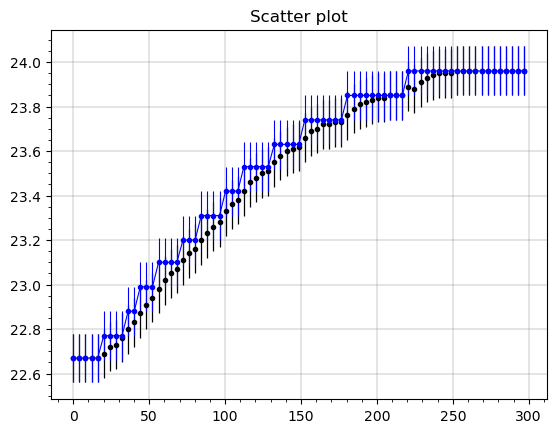

In [6]:
#let's see data: scatter plot with error bars
plt.errorbar(t_ema_r,T_ema_r, dT_ema, linestyle = '',linewidth = 0.9, color = 'black', marker = '.')
plt.errorbar(t_r,Troom_r, dT, linestyle = '-',linewidth = 0.8, color = 'blue', marker = '.')
plt.title('Scatter plot')
plt.grid(color='gray',linewidth='0.3')
plt.minorticks_on()

In [7]:
#define the fit function 
# A=costante , B=ampiezza , tau=tempo caratteristico

def exp(t, A, B, tau):     
    return  A + B * np.exp(-t/tau)

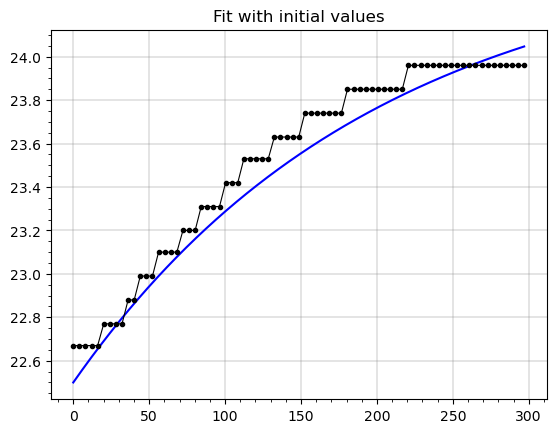

In [8]:
#define the initial values
init=(24.5, -2, 200) 

# prepare a dummy xx array (with 2000 linearly spaced points)
xx=np.linspace(min(t_r),max(t_r),2000)

# plot the fitting curve computed with initial values
plt.plot(xx,exp(xx,*init), color='blue') 
plt.errorbar(t_r,Troom_r,linestyle = '-',linewidth = 0.8, color = 'black', marker = '.')
plt.title('Fit with initial values')
plt.grid(color='gray',linewidth='0.3')
plt.minorticks_on()

In [9]:
#call the minimization routine
pars,covm = curve_fit(exp,t_r,Troom_r,init)
err = np.sqrt (covm.diagonal())

#print results on the console
print(f'A  = {pars[0]:.4f} +/- {err[0]:.4f}')
print(f'B = {pars[1]:.4f} +/- {err[1]:.4f}')
print(f'tau = {pars[2]:.4f} +/- {err[2]:.4f}')

#NOTE: it's okay to use no errors and absolute_sigma=False 'cause dT is the same
#for all y data, it means that the fit is not weighted. Infact as you
#can see below there is no difference in obtained results

A  = 24.2425 +/- 0.0368
B = -1.7258 +/- 0.0307
tau = 139.5945 +/- 7.3201


In [10]:
#using the Chi2 test
# set the error
sigma = dT
w = 1/sigma**2

#call the minimization routine
pars_e,covm_e = curve_fit(exp,t_r,Troom_r,init, sigma=dT, absolute_sigma=True)
err_e = np.sqrt (covm.diagonal())

#calculate the chisquare for the best-fit function
chi2 = ((w*(Troom_r-exp(t_r,*pars_e))**2)).sum()

# determine the ndof
ndof=len(t_r)-len(init)

# print results on the console
print('pars:',pars)
print('covm:',covm)
print ('chi2, ndof:',chi2, ndof)

pars: [ 24.24247372  -1.72580309 139.59451586]
covm: [[ 1.35333648e-03 -9.41604803e-04  2.56919156e-01]
 [-9.41604803e-04  9.44973773e-04 -1.51613788e-01]
 [ 2.56919156e-01 -1.51613788e-01  5.35834028e+01]]
chi2, ndof: 14.358871163035706 72


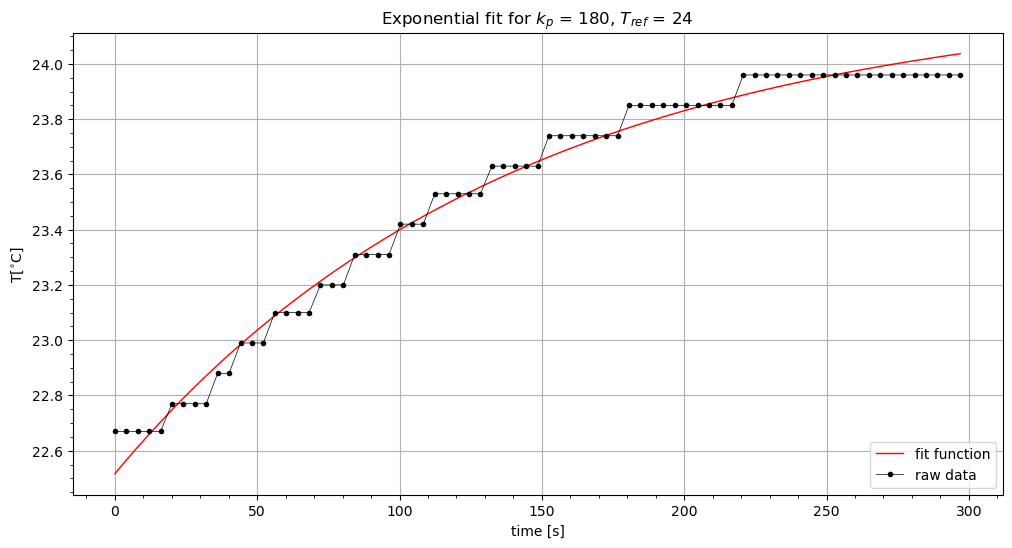

In [12]:
#plot the best fit curve

plt.rc('font',size=10)
plt.figure(figsize=(12,6))
plt.title(r"Exponential fit for $k_p$ = %d, $T_{ref}$ = %d " % (kp, Tref))
plt.xlabel("time [s]")
plt.ylabel("T[$^{\circ}$C]")
plt.grid(True)
plt.minorticks_on()

plt.plot(xx,exp(xx,*pars), color='red',linewidth='1', label = 'fit function')
plt.errorbar(t_r,Troom_r,linestyle = '-', color = 'black', marker = '.', linewidth='0.5', label = 'raw data')
plt.legend(loc='lower right', fancybox=True)

#save the plot in the results dir
out_name = os.path.join(results_dir,f"Pcontrol_kp{kp}_Tref{Tref}.png")
plt.savefig(out_name)
plt.show()